# Implementing Prompt Caching with Claude on Amazon Bedrock

This notebook demonstrates how to implement prompt caching with Claude models on Amazon Bedrock, providing code examples for both the invoke_model and converse APIs, as well as using the Anthropic Bedrock SDK. We'll explore different approaches to caching prompts efficiently.

## Introduction

Prompt caching allows you to reuse parts of prompts that don't change between requests, reducing token usage and latency. This is particularly valuable when working with large context windows or when repeatedly sending similar prompts.

## Setup

First, let's set up our environment by importing necessary libraries and creating a Bedrock client.

In [18]:
# Install required packages. boto3 1.37.24+ is needed for converse API support
!pip install --upgrade anthropic boto3==1.37.24 botocore==1.37.24

In [20]:
import boto3
from anthropic import AnthropicBedrock
import json
import time
import os

# Initialize a session with your AWS profile
session = boto3.Session()

# Create a Bedrock runtime client
bedrock_runtime = session.client('bedrock-runtime')

# Initialize the Anthropic Bedrock SDK
client = AnthropicBedrock()

## Loading Example Text

For our examples, we'll load a sample text document. In a real application, this could be a long document, a knowledge base, or any other text that you want to repeatedly query.

In [5]:
# Load the sample text from bedrock_docs.txt
with open('RomeoAndJuliet.txt', 'r') as file:
    sample_text = file.read()

# Print the first few characters to verify it loaded correctly
print(f"Loaded {len(sample_text)} characters from bedrock_docs.txt")
print(f"Preview: {sample_text[:100]}...")

Loaded 161777 characters from bedrock_docs.txt
Preview: ﻿The Project Gutenberg eBook of Romeo and Juliet
    
This ebook is for the use of anyone anywhere i...


## Basic Model Invocation

Before we explore prompt caching, let's first look at how to call Claude models on Amazon Bedrock using both the invoke_model and converse APIs. This will help establish a baseline understanding.

### The invoke_model API

The `invoke_model` API can be used to call Claude models on Amazon Bedrock. Here's a simple example without caching:

In [7]:
# Example of basic invoke_model usage (without caching)
response = bedrock_runtime.invoke_model(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    contentType='application/json',
    body=json.dumps({
        'anthropic_version': 'bedrock-2023-05-31',
        'system': 'You are a helpful assistant that answers questions concisely.',
        'max_tokens': 256,
        'temperature': 0.7,
        'messages': [
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'text',
                        'text': 'What is prompt caching in Claude on Amazon Bedrock?'
                    }
                ]
            }
        ]
    })
)

# Parse the response
response_body = json.loads(response['body'].read().decode('utf-8'))
print("Basic invoke_model response:")
print(response_body['content'][0]['text'])

Basic invoke_model response:
Prompt caching in Claude on Amazon Bedrock is a feature that stores frequently used prompts to reduce costs and latency. When you submit a request that matches a cached prompt, Bedrock returns the cached response without charging for input tokens in that portion, only charging for output tokens. This is particularly useful for applications with repetitive prompt patterns.


### The converse API

The `converse` API provides a standardized interface for multi-turn conversations. Here's a simple example without caching:

In [8]:
# Example of basic converse API usage (without caching)
converse_response = bedrock_runtime.converse(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    messages=[
        {
            'role': 'user',
            'content': [
                {
                    'text': 'What is prompt caching in Claude on Amazon Bedrock?'
                }
            ]
        }
    ],
    system=[
        {
            'text': 'You are a helpful assistant that answers questions concisely.'
        }
    ],
    inferenceConfig={
        'maxTokens': 256,
        'temperature': 0.7,
        'topP': 0.8
    }
)

print("Basic converse API response:")
print(converse_response['output']['message']['content'][0]['text'])

Basic converse API response:
Prompt caching in Claude on Amazon Bedrock is a feature that stores and reuses the results of identical prompts, reducing costs and latency. When you send a prompt that exactly matches a previously cached one, Bedrock returns the cached response instead of processing it again, which saves on token usage charges and delivers faster responses.


## Implementing Basic Prompt Caching

Now let's learn how to implement prompt caching with both APIs. The basic idea is to mark portions of your prompt that should be cached for reuse in subsequent requests.

### Caching with invoke_model API

For the `invoke_model` API, you use the `cache_control` attribute in content blocks to mark portions of your prompt for caching:

In [9]:
# Example of invoke_model API with caching
print("Making first request with caching...")
response_cache_1 = bedrock_runtime.invoke_model(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    contentType='application/json',
    body=json.dumps({
        'anthropic_version': 'bedrock-2023-05-31',
        'system': 'You are a helpful assistant that answers questions concisely.',
        'max_tokens': 256,
        'temperature': 0.7,
        'messages': [
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'text',
                        'text': 'Explain the following text: '
                    },
                    {
                        'type': 'text',
                        'text': sample_text,
                        'cache_control': {
                            'type': 'ephemeral'  # Mark this content for caching
                        }
                    }
                ]
            }
        ]
    })
)

# Get the response and any metrics
response_body_cache_1 = json.loads(response_cache_1['body'].read().decode('utf-8'))
metrics_cache_1 = response_body_cache_1.get('usage', {})

print("First response:")
print(response_body_cache_1['content'][0]['text'])
print(f"\nMetrics:")
print(f"Input tokens: {metrics_cache_1.get('input_tokens', 'N/A')}")
print(f"Output tokens: {metrics_cache_1.get('output_tokens', 'N/A')}")
print(f"Cache write tokens: {metrics_cache_1.get('cache_creation_input_tokens', 'N/A')}")
print(f"Cache read tokens: {metrics_cache_1.get('cache_read_input_tokens', 'N/A')}")

Making first request with caching...
First response:
# Romeo and Juliet: Project Gutenberg eBook Overview

This text is the complete Project Gutenberg eBook of William Shakespeare's "Romeo and Juliet." The document begins with standard Project Gutenberg license information, indicating that this work is in the public domain and available for free use in the United States and most other parts of the world.

## Content Details:
- **Title**: Romeo and Juliet
- **Author**: William Shakespeare
- **Release date**: Originally November 1, 1998 (eBook #1513), most recently updated June 19, 2024
- **Language**: English
- **Credits**: Created by the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers

The eBook contains the complete text of the classic tragedy, including:
- A prologue
- Five acts with multiple scenes
- A complete dramatis personae (character list) including the Montague and Capulet families, their servants, and other characters like Friar Lawrence, the Nurse, 

In [10]:
# Second request with the same cached content
print("\nMaking second request with cached content...")
response_cache_2 = bedrock_runtime.invoke_model(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    contentType='application/json',
    body=json.dumps({
        'anthropic_version': 'bedrock-2023-05-31',
        'system': 'You are a helpful assistant that answers questions concisely.',
        'max_tokens': 256,
        'temperature': 0.7,
        'messages': [
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'text',
                        'text': 'Explain the following text: '
                    },
                    {
                        'type': 'text',
                        'text': sample_text,
                        'cache_control': {
                            'type': 'ephemeral'  # Same cached content
                        }
                    }
                ]
            }
        ]
    })
)
# Get the response and any metrics
response_body_cache_2 = json.loads(response_cache_2['body'].read().decode('utf-8'))
metrics_cache_2 = response_body_cache_2.get('usage', {})

print("Second response:")
print(response_body_cache_2['content'][0]['text'])
print(f"\nMetrics:")
print(f"Input tokens: {metrics_cache_2.get('input_tokens', 'N/A')}")
print(f"Output tokens: {metrics_cache_2.get('output_tokens', 'N/A')}")
print(f"Cache write tokens: {metrics_cache_2.get('cache_creation_input_tokens', 'N/A')}")
print(f"Cache read tokens: {metrics_cache_2.get('cache_read_input_tokens', 'N/A')}")


Making second request with cached content...
Second response:
This text is a complete copy of William Shakespeare's play "Romeo and Juliet" from Project Gutenberg. Here's a brief explanation:

The text begins with standard Project Gutenberg header information, explaining that the work is freely available in the public domain in the United States and most other parts of the world. It notes that this is William Shakespeare's "Romeo and Juliet," first released by Project Gutenberg in November 1998 (eBook #1513) and most recently updated in June 2024.

The play itself follows the traditional five-act structure of Shakespearean tragedy. It tells the story of two young lovers, Romeo Montague and Juliet Capulet, whose families are engaged in a long-standing feud in Verona, Italy. The play chronicles their secret romance, marriage, and ultimately their tragic deaths, which finally bring their feuding families together in grief and reconciliation.

The text includes a complete table of content

### Caching with converse API

For the `converse` API, you use the `cachePoint` attribute to mark where cache boundaries should be placed:

In [11]:
# Example of converse API with caching
print("Making first converse request with caching...")
converse_cache_1 = bedrock_runtime.converse(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    messages=[
        {
            'role': 'user',
            'content': [
                {
                    'text': 'Summarize the following text in 10 words: '
                },
                {
                    'text': sample_text
                },
                {
                    'cachePoint': {
                        'type': 'default'  # Insert a cache point after the question
                    }
                }
            ]
        }
    ],
    system=[
        {
            'text': 'You are a helpful assistant that answers questions concisely.'
        }
    ],
    inferenceConfig={
        'maxTokens': 256,
        'temperature': 0.7,
        'topP': 0.8
    }
)

# Print results and metrics
print("First converse response:")
print(converse_cache_1['output']['message']['content'][0]['text'])
print(f"\nMetrics:")
print(f"Input tokens: {converse_cache_1['usage'].get('inputTokens', 'N/A')}")
print(f"Output tokens: {converse_cache_1['usage'].get('outputTokens', 'N/A')}")
print(f"Cache write tokens: {converse_cache_1['usage'].get('cacheWriteInputTokens', 'N/A')}")
print(f"Cache read tokens: {converse_cache_1['usage'].get('cacheReadInputTokens', 'N/A')}")

Making first converse request with caching...
First converse response:
# Romeo and Juliet: Project Gutenberg eBook Summary

Shakespeare's tragedy about two young lovers from feuding families in Verona. Their secret marriage ends in tragedy when miscommunication leads to their suicides.

Metrics:
Input tokens: 4
Output tokens: 50
Cache write tokens: 50120
Cache read tokens: 0


In [12]:
# Second converse request with caching
print("\nMaking second converse request with caching...")
converse_cache_2 = bedrock_runtime.converse(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    messages=[
        {
            'role': 'user',
            'content': [
                {
                    'text': 'Summarize the following text in 10 words: '
                },
                {
                    'text': sample_text
                },
                {
                    'cachePoint': {
                        'type': 'default'  # Insert a cache point after the question
                    }
                }
            ]
        }
    ],
    system=[
        {
            'text': 'You are a helpful assistant that answers questions concisely.'
        },
        {
            'cachePoint': {
                'type': 'default'  # Cache the system prompt too
            }
        }
    ],
    inferenceConfig={
        'maxTokens': 256,
        'temperature': 0.7,
        'topP': 0.8
    }
)

# Print results and metrics
print("Second converse response:")
print(converse_cache_2['output']['message']['content'][0]['text'])
print(f"\nMetrics:")
print(f"Input tokens: {converse_cache_2['usage'].get('inputTokens', 'N/A')}")
print(f"Output tokens: {converse_cache_2['usage'].get('outputTokens', 'N/A')}")
print(f"Cache write tokens: {converse_cache_2['usage'].get('cacheWriteInputTokens', 'N/A')}")
print(f"Cache read tokens: {converse_cache_2['usage'].get('cacheReadInputTokens', 'N/A')}")


Making second converse request with caching...
Second converse response:
# Romeo and Juliet: A Concise Summary

Shakespeare's tragic love story about feuding families and star-crossed lovers.

Metrics:
Input tokens: 4
Output tokens: 31
Cache write tokens: 0
Cache read tokens: 50120


### Key Differences Between invoke_model and converse API Caching

| Feature | invoke_model API | converse API |
|---------|-----------------|--------------|
| Cache marker | `cache_control` attribute | `cachePoint` attribute |
| Location | Inside content blocks | Can be placed in messages, system prompts, and tools |
| Type | Uses `"type": "ephemeral"` | Uses `"type": "default"` |
| Metrics | In `amazon-bedrock-invocationMetrics` | In the top-level `usage` object |

## Caching with Anthropic SDK on Bedrock

The Anthropic SDK also supports caching through the `cache_control` attribute, similar to the invoke_model API:

In [22]:
# First request with anthropic SDK
print("Making first request with anthropic SDK...")
start_time = time.time()
response = client.messages.create(
    model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    max_tokens=256,
    temperature=0.7,
    system=[
        {
            "type": "text", 
            "text": "You are a helpful assistant that answers questions concisely."
        }
    ],
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Explain the story: "
                },
                {
                    "type": "text",
                    "text": sample_text,
                    "cache_control": {
                        "type": "ephemeral"  # Cache this content
                    }
                }
            ]
        }
    ]
)

end_time = time.time()
invocation_latency = end_time - start_time

# Get the response and any metrics
metrics = response.usage

print("First response:")
print(response.content[0].text)
print(f"\nMetrics:")
print(f"Input tokens: {metrics.input_tokens}")
print(f"Output tokens: {metrics.output_tokens}")
print(f"Cache write tokens: {metrics.cache_creation_input_tokens}")
print(f"Cache read tokens: {metrics.cache_read_input_tokens}")
print(f"Invocation latency: {invocation_latency:.2f} seconds")


Making first request with anthropic SDK...
First response:
# Romeo and Juliet: A Summary

"Romeo and Juliet" is Shakespeare's famous tragedy about two young lovers from feuding families in Verona. The story unfolds over five acts:

## The Feud and First Meeting

The play opens with a street brawl between servants of the Montague and Capulet households, revealing their long-standing feud. Romeo Montague, heartbroken over unrequited love for Rosaline, is persuaded by his friend Benvolio to attend a Capulet feast. There, Romeo meets and instantly falls in love with Juliet Capulet. They share an immediate connection despite learning they belong to enemy families.

## Secret Marriage

After the feast, Romeo sneaks into the Capulet garden where he overhears Juliet professing her love for him on her balcony. They declare their love for each other and decide to marry secretly the next day. Friar Lawrence agrees to perform the ceremony, hoping their union might reconcile the feuding families.



In [23]:
# Second request with anthropic SDK
print("Making second request with anthropic SDK...")
start_time = time.time()
response = client.messages.create(
    model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    max_tokens=256,
    temperature=0.7,
    system=[
        {
            "type": "text", 
            "text": "You are a helpful assistant that answers questions concisely."
        }
    ],
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Explain the story: "
                },
                {
                    "type": "text",
                    "text": sample_text,
                    "cache_control": {
                        "type": "ephemeral"  # Cache this content
                    }
                }
            ]
        }
    ]
)

end_time = time.time()
invocation_latency = end_time - start_time

# Get the response and any metrics
metrics = response.usage

print("Second response:")
print(response.content[0].text)
print(f"\nMetrics:")
print(f"Input tokens: {metrics.input_tokens}")
print(f"Output tokens: {metrics.output_tokens}")
print(f"Cache write tokens: {metrics.cache_creation_input_tokens}")
print(f"Cache read tokens: {metrics.cache_read_input_tokens}")
print(f"Invocation latency: {invocation_latency:.2f} seconds")


Making second request with anthropic SDK...
Second response:
"Romeo and Juliet" is one of Shakespeare's most famous tragedies. The text you shared is the complete play from Project Gutenberg.

The story follows two young lovers, Romeo Montague and Juliet Capulet, whose families are engaged in a long-standing feud in Verona, Italy. After meeting at a Capulet ball where Romeo sneaks in wearing a mask, they fall deeply in love despite their families' hatred for each other.

With the help of Friar Lawrence, they marry in secret. However, tragedy strikes when Romeo kills Juliet's cousin Tybalt in a duel after Tybalt had killed Romeo's friend Mercutio. Romeo is banished from Verona, and Juliet's parents arrange for her to marry Paris.

To avoid this unwanted marriage, Juliet takes a potion from Friar Lawrence that makes her appear dead, with a plan for Romeo to retrieve her from the family tomb. However, the message explaining this plan fails to reach Romeo. Believing Juliet truly dead, Rome

## Benchmarking Prompt Caching

Now let's conduct a more formal benchmark to measure the performance improvements from prompt caching when working with larger text documents:

In [13]:
# Create a data structure to track request metrics
request_metrics = {
    'invoke_model': {
        'first_request': {
            'TTFT': None,
            'invocation_latency': None,
            'input_tokens': None,
            'output_tokens': None,
            'cache_read_tokens': 0,
            'cache_write_tokens': 0,
            'tokens_per_second': None,
            'decoding_tokens_per_second': None
        },
        'second_request': {
            'TTFT': None,
            'invocation_latency': None,
            'input_tokens': None,
            'output_tokens': None,
            'cache_read_tokens': 0,
            'cache_write_tokens': 0,
            'tokens_per_second': None,
            'decoding_tokens_per_second': None
        }
    },
    'converse': {
        'first_request': {
            'TTFT': None,
            'invocation_latency': None,
            'input_tokens': None,
            'output_tokens': None,
            'cache_read_tokens': 0,
            'cache_write_tokens': 0,
            'tokens_per_second': None,
            'decoding_tokens_per_second': None
        },
        'second_request': {
            'TTFT': None,
            'invocation_latency': None,
            'input_tokens': None,
            'output_tokens': None,
            'cache_read_tokens': 0,
            'cache_write_tokens': 0,
            'tokens_per_second': None,
            'decoding_tokens_per_second': None
        }
    }
}

# Helper function to record timing metrics
def record_timing(api_type, request_type, duration, time_to_first_token, metrics=None):
    decoding_time = duration - time_to_first_token
    
    # Record token usage if metrics is provided
    if metrics:
        request_metrics[api_type][request_type]['input_tokens'] = metrics.get('inputTokenCount', 0) + metrics.get('cacheWriteInputTokenCount', 0)
        request_metrics[api_type][request_type]['output_tokens'] = metrics.get('outputTokenCount', 0)
        request_metrics[api_type][request_type]['cache_read_tokens'] = metrics.get('cacheReadInputTokenCount', 0)
        request_metrics[api_type][request_type]['cache_write_tokens'] = metrics.get('cacheWriteInputTokenCount', 0)
        request_metrics[api_type][request_type]['invocation_latency'] = metrics.get('cacheWriteInputTokenCount', 0)
        request_metrics[api_type][request_type]['TTFT'] = time_to_first_token
        request_metrics[api_type][request_type]['invocation_latency'] = duration
        # Calculate tokens per second
        if duration > 0:
            tokens_per_second = metrics.get('outputTokenCount', 0) / duration
            request_metrics[api_type][request_type]['tokens_per_second'] = tokens_per_second
        # Calculate decoding tokens per second if decoding time is provided
        if decoding_time and decoding_time > 0:
            decoding_tokens_per_second = metrics.get('outputTokenCount', 0) / decoding_time
            request_metrics[api_type][request_type]['decoding_tokens_per_second'] = decoding_tokens_per_second

In [14]:
# First request with prompt caching enabled - using streaming API
print("Making first request with streaming...")
start_time = time.time()
request_body = json.dumps({
    'anthropic_version': 'bedrock-2023-05-31',
    'system': 'Reply concisely',
    'max_tokens': 512,
    'temperature': 0.5,
    'top_p': 0.8,
    'top_k': 250,
    'messages': [
        {
            'role': 'user',
            'content': [
                {
                    'type': 'text',
                    'text': 'Summarize the following text in 250 words: '
                },
                {
                    'type': 'text',
                    'text': sample_text,
                    'cache_control': {
                        'type': 'ephemeral'  # Mark this content for caching
                    }
                }
            ]
        }
    ]
})

# Start streaming response
stream_response = bedrock_runtime.invoke_model_with_response_stream(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    contentType='application/json',
    body=request_body
)

# Measure prefill latency (time to first byte)
first_byte_received = False
prefill_latency = None
full_response = ""
token_count = 0
stream_start_time = None

# Process the streaming response
metrics = None
for event in stream_response['body']:
    if 'chunk' in event:
        chunk_data = json.loads(event['chunk']['bytes'].decode())
        
        # Check if this is the message_stop chunk with metrics
        if 'type' in chunk_data and chunk_data['type'] == 'message_stop' and 'amazon-bedrock-invocationMetrics' in chunk_data:
            metrics = chunk_data['amazon-bedrock-invocationMetrics']
        
        if not first_byte_received:
            first_byte_received = True
            prefill_latency = time.time() - start_time
            stream_start_time = time.time()
            print(f"Prefill latency (time to first byte): {prefill_latency:.4f} seconds")
        
        if 'content' in chunk_data and len(chunk_data['content']) > 0:
            chunk_text = chunk_data['content'][0]['text']
            full_response += chunk_text

# Record timing metrics
total_duration = time.time() - start_time

record_timing('invoke_model', 'first_request', total_duration, prefill_latency, metrics)

# Print the full response
print(f"First response (completed in {total_duration:.2f} seconds):")
print(full_response)

Making first request with streaming...
Prefill latency (time to first byte): 8.9334 seconds
First response (completed in 22.12 seconds):



Now let's make a second request using the same cached prompt. This should be faster and use fewer tokens since the sample text is already cached.

In [15]:
# Second request with prompt caching enabled - using streaming API
print("Making second request with streaming (using cached prompt)...")
start_time = time.time()
request_body = json.dumps({
    'anthropic_version': 'bedrock-2023-05-31',
    'system': 'Reply concisely',
    'max_tokens': 512,
    'temperature': 0.5,
    'top_p': 0.8,
    'top_k': 250,
    'messages': [
        {
            'role': 'user',
            'content': [
                {
                    'type': 'text',
                    'text': 'Summarize the following text in 250 words: '
                },
                {
                    'type': 'text',
                    'text': sample_text,
                    'cache_control': {
                        'type': 'ephemeral'  # Mark this content for caching
                    }
                }
            ]
        }
    ]
})

# Start streaming response
stream_response = bedrock_runtime.invoke_model_with_response_stream(
    modelId='us.anthropic.claude-3-7-sonnet-20250219-v1:0',
    contentType='application/json',
    body=request_body
)

# Measure prefill latency (time to first byte)
first_byte_received = False
prefill_latency = None
full_response = ""
token_count = 0
stream_start_time = None

# Process the streaming response
metrics = None
for event in stream_response['body']:
    if 'chunk' in event:
        chunk_data = json.loads(event['chunk']['bytes'].decode())
        
        # Check if this is the message_stop chunk with metrics
        if 'type' in chunk_data and chunk_data['type'] == 'message_stop' and 'amazon-bedrock-invocationMetrics' in chunk_data:
            metrics = chunk_data['amazon-bedrock-invocationMetrics']
        
        if not first_byte_received:
            first_byte_received = True
            prefill_latency = time.time() - start_time
            stream_start_time = time.time()
            print(f"Prefill latency (time to first byte): {prefill_latency:.4f} seconds")
        
        if 'content' in chunk_data and len(chunk_data['content']) > 0:
            chunk_text = chunk_data['content'][0]['text']
            full_response += chunk_text

# Record timing metrics
total_duration = time.time() - start_time

record_timing('invoke_model', 'second_request', total_duration, prefill_latency, metrics)

# Print the full response
print(f"First response (completed in {total_duration:.2f} seconds):")
print(full_response)

Making second request with streaming (using cached prompt)...
Prefill latency (time to first byte): 5.7548 seconds
First response (completed in 21.91 seconds):



## Analyzing Cache Performance

Let's visualize the token usage and latency improvements from using prompt caching.

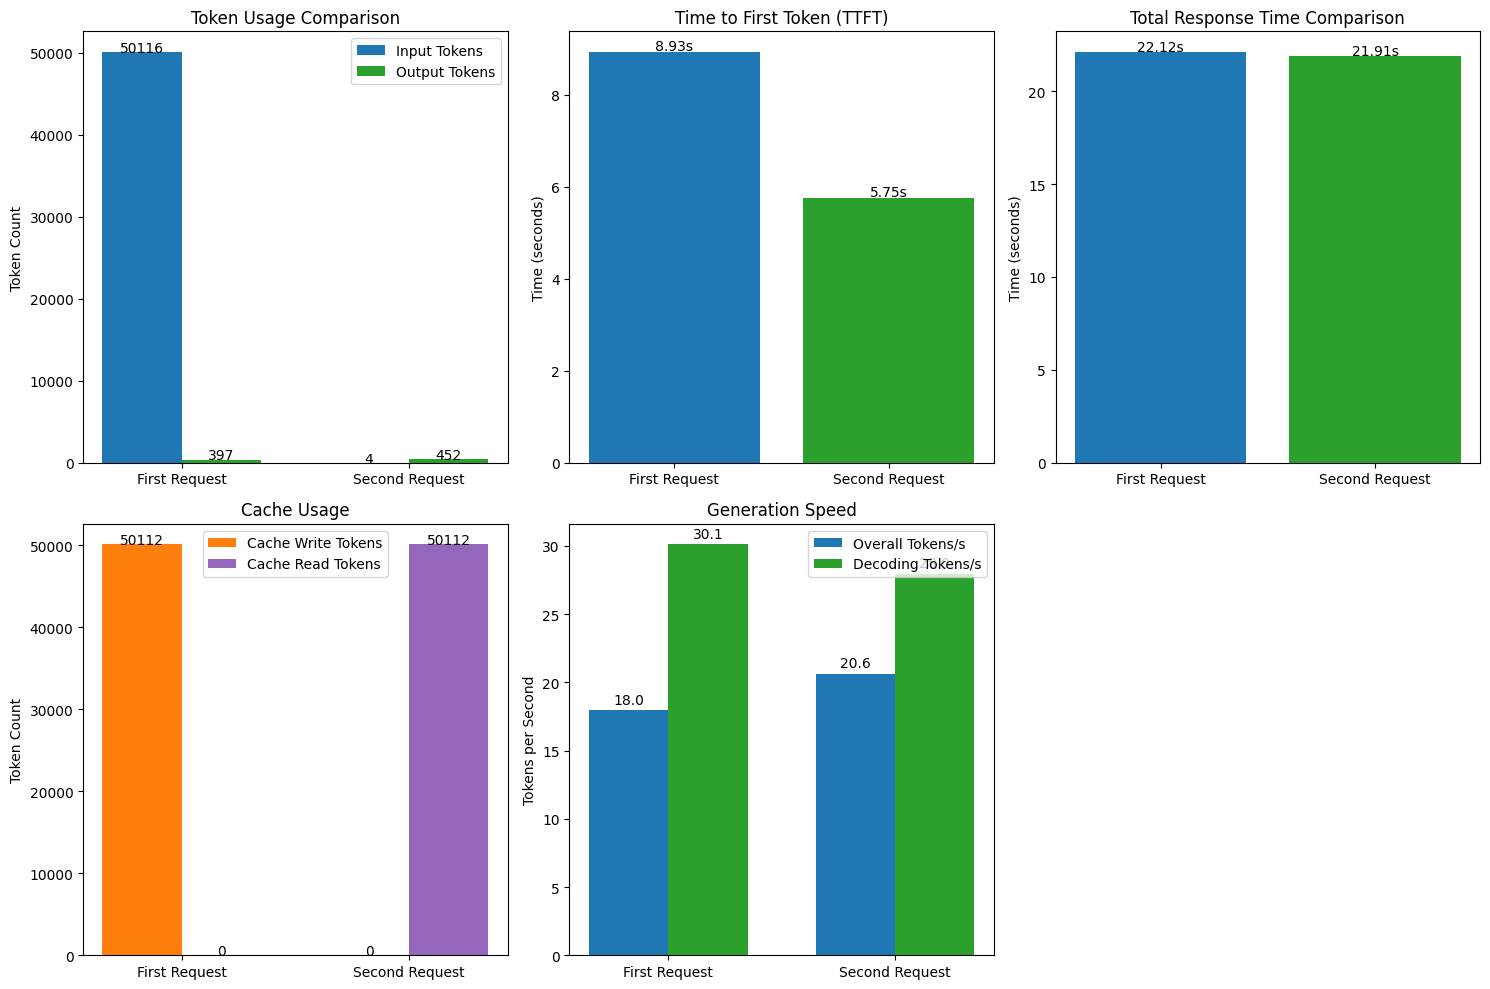

Cache Efficiency Summary:
Token reduction: 100.0%
Response time improvement: 0.9%
Tokens read from cache: 50112


In [17]:
# Import visualization library
import matplotlib.pyplot as plt
import numpy as np

# Extract data from request_metrics
first_request = request_metrics['invoke_model']['first_request']
second_request = request_metrics['invoke_model']['second_request']

# Create figure with multiple subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 1. Token Usage Comparison
labels = ['First Request', 'Second Request']
input_tokens = [first_request['input_tokens'], second_request['input_tokens']]
output_tokens = [first_request['output_tokens'], second_request['output_tokens']]

x = np.arange(len(labels))
width = 0.35

axs[0, 0].bar(x - width/2, input_tokens, width, label='Input Tokens', color='#1f77b4')
axs[0, 0].bar(x + width/2, output_tokens, width, label='Output Tokens', color='#2ca02c')
axs[0, 0].set_ylabel('Token Count')
axs[0, 0].set_title('Token Usage Comparison')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(labels)
axs[0, 0].legend()

for i, v in enumerate(input_tokens):
    axs[0, 0].text(i - width/2, v + 5, str(v), ha='center')
for i, v in enumerate(output_tokens):
    axs[0, 0].text(i + width/2, v + 5, str(v), ha='center')

# 2. TTFT Comparison
ttft_values = [first_request['TTFT'], second_request['TTFT']]
axs[0, 1].bar(labels, ttft_values, color=['#1f77b4', '#2ca02c'])
axs[0, 1].set_ylabel('Time (seconds)')
axs[0, 1].set_title('Time to First Token (TTFT)')
for i, v in enumerate(ttft_values):
    if v is not None:
        axs[0, 1].text(i, v + 0.05, f"{v:.2f}s", ha='center')

# 3. Total Response Time Comparison
invocation_latency = [first_request['invocation_latency'], second_request['invocation_latency']]
axs[0, 2].bar(labels, invocation_latency, color=['#1f77b4', '#2ca02c'])
axs[0, 2].set_ylabel('Time (seconds)')
axs[0, 2].set_title('Total Response Time Comparison')
for i, v in enumerate(invocation_latency):
    if v is not None:
        axs[0, 2].text(i, v + 0.05, f"{v:.2f}s", ha='center')

# 4. Cache Usage
cache_read = [first_request['cache_read_tokens'], second_request['cache_read_tokens']]
cache_write = [first_request['cache_write_tokens'], second_request['cache_write_tokens']]

axs[1, 0].bar(x - width/2, cache_write, width, label='Cache Write Tokens', color='#ff7f0e')
axs[1, 0].bar(x + width/2, cache_read, width, label='Cache Read Tokens', color='#9467bd')
axs[1, 0].set_ylabel('Token Count')
axs[1, 0].set_title('Cache Usage')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(labels)
axs[1, 0].legend()

for i, v in enumerate(cache_write):
    axs[1, 0].text(i - width/2, v + 5, str(v), ha='center')
for i, v in enumerate(cache_read):
    axs[1, 0].text(i + width/2, v + 5, str(v), ha='center')

# 5. Tokens Per Second
tokens_per_second = [first_request['tokens_per_second'], second_request['tokens_per_second']]
decoding_tokens_per_second = [first_request['decoding_tokens_per_second'], second_request['decoding_tokens_per_second']]

axs[1, 1].bar(x - width/2, tokens_per_second, width, label='Overall Tokens/s', color='#1f77b4')
axs[1, 1].bar(x + width/2, decoding_tokens_per_second, width, label='Decoding Tokens/s', color='#2ca02c')
axs[1, 1].set_ylabel('Tokens per Second')
axs[1, 1].set_title('Generation Speed')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(labels)
axs[1, 1].legend()

for i, v in enumerate(tokens_per_second):
    if v is not None:
        axs[1, 1].text(i - width/2, v + 0.5, f"{v:.1f}", ha='center')
for i, v in enumerate(decoding_tokens_per_second):
    if v is not None:
        axs[1, 1].text(i + width/2, v + 0.5, f"{v:.1f}", ha='center')

# Hide the empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Calculate and display cache efficiency metrics
if second_request['input_tokens'] and first_request['input_tokens']:
    token_reduction_pct = ((first_request['input_tokens'] - second_request['input_tokens']) / 
                          first_request['input_tokens']) * 100
    time_reduction_pct = ((first_request['invocation_latency'] - second_request['invocation_latency']) / 
                         first_request['invocation_latency']) * 100
    
    print(f"Cache Efficiency Summary:")
    print(f"Token reduction: {token_reduction_pct:.1f}%")
    print(f"Response time improvement: {time_reduction_pct:.1f}%")
    print(f"Tokens read from cache: {second_request['cache_read_tokens']}")

## Optimal Caching Strategies

Here are some best practices for implementing prompt caching with Claude on Bedrock:

### 1. Cache static content

Identify parts of your prompts that don't change between requests:
- Long documents or context windows
- System prompts
- Tool definitions
- Reference information

### 2. Place cache points strategically

For the Converse API, you can place cache points in:
- Messages (user/assistant content)
- System prompts
- Tool definitions

### 3. Monitor cache performance

Track the following metrics to ensure optimal caching:
- cacheReadInputTokens: How many tokens were read from cache
- cacheWriteInputTokens: How many tokens were written to cache
- Response latency improvements

## Conclusion

Prompt caching with Claude on Amazon Bedrock provides significant benefits:

1. **Cost optimization**: Reduce token usage by caching parts of prompts
2. **Latency improvements**: Faster responses when reusing cached content
3. **Flexibility**: Cache different portions of requests (messages, system prompts, tools)

By implementing the techniques shown in this notebook, you can optimize your Claude applications for both performance and cost efficiency. The advanced use cases and prompt restructuring strategies should help you apply prompt caching to your specific applications.

Remember to measure and monitor your caching performance to ensure you're getting the expected benefits. Different applications may require different approaches, so experimentation is key to finding the optimal caching strategy for your needs.